In [301]:
import pandas as pd
import math

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
from xgboost import plot_tree
from sklearn.metrics import r2_score

df_train = pd.read_csv('./csv/train.csv')
df_store = pd.read_csv('./csv/stores.csv')
df_feat = pd.read_csv('./csv/features.csv')


In [302]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_feat['Date'] = pd.to_datetime(df_feat['Date'])

In [303]:
df = pd.merge(df_train, df_feat, on=['Store', 'Date', 'IsHoliday'], how='left' )
df = pd.merge(df, df_store, on=['Store'], how='left' )
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


In [304]:
fill_na_cols = [ 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5' ]

for c in fill_na_cols:
    df[c] = df[c].fillna(0)
    
df['MarkDown'] = df[fill_na_cols].sum(axis=1)
# df['MarkDown'] = df['MarkDown3'].copy()
# df = df.drop(columns = fill_na_cols)

In [305]:
df['year'] = df['Date'].dt.year
df['week'] = df['Date'].dt.week
df['month'] = df['Date'].dt.month

# df = df.drop(columns = ['Date'])

/tmp/ipykernel_247/3234748729.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['Date'].dt.week


In [306]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,MarkDown,year,week,month
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,0.0,2010,5,2
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,0.0,2010,6,2
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,0.0,2010,7,2
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,0.0,2010,8,2
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,0.0,2010,9,3


In [307]:
label=LabelEncoder()

cols = ['Type', 'IsHoliday']

for c in cols:
    df[c] = label.fit_transform(df[c])
    df[c] = df[c].astype('category')

In [308]:
df = df.sample(frac=1, random_state=1)

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 367951 to 128037
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  category      
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     421570 non-null  float64       
 8   MarkDown2     421570 non-null  float64       
 9   MarkDown3     421570 non-null  float64       
 10  MarkDown4     421570 non-null  float64       
 11  MarkDown5     421570 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  category      
 15  Size        

In [310]:
df = df[ ['Weekly_Sales', 'Store','Dept','IsHoliday','Size','week','Type','year', 'Date'] ]

In [311]:
train_num = int( 0.8 * len(df) )
df_train = df[:train_num]

df_val = df[train_num:]

len(df_train), len(df_val)

(337256, 84314)

In [312]:
def WMAE(pred, gtruth, is_holiday):
    weights = is_holiday.astype('int').apply(lambda x: 5 if x==1 else 1) 
    tmp = weights * abs(pred-gtruth)
    return tmp.sum()/weights.sum()

In [313]:
X_train = df_train.drop(columns = ['Weekly_Sales', 'Date'])
Y_train = df_train['Weekly_Sales']


reg = xgb.XGBRegressor(tree_method = 'gpu_hist', objective='reg:squarederror', max_depth=10, n_estimators= 300, learning_rate=0.1, subsample = 0.9,
                      enable_categorical=True)

reg.fit(X_train, Y_train )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=14, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [314]:
pred = pd.Series( reg.predict(X_train) ).apply(lambda x: 0 if x < 0 else x )
#pred = pd.Series( reg.predict(X_train) )

print( r2_score( pred,Y_train.reset_index(drop=True) ) )
print( np.mean( np.absolute( np.array( Y_train.tolist() ) - pred ) ) )
print( WMAE(pred, Y_train.reset_index(drop=True), 
     X_train['IsHoliday'].reset_index(drop=True)) )

0.9992746889741213
373.23642947728763
355.4724310748758


In [315]:
X_val = df_val.drop(columns = ['Weekly_Sales', 'Date'])
Y_val = df_val['Weekly_Sales']

pred = pd.Series( reg.predict(X_val) ).apply(lambda x: 0 if x < 0 else x )
#pred = pd.Series( reg.predict(X_val) )

print( r2_score( pred,Y_val.reset_index(drop=True) ) )
print( np.mean( np.absolute( np.array( Y_val.tolist() ) - pred ) ) )
print( WMAE(pred, Y_val.reset_index(drop=True), 
     X_val['IsHoliday'].reset_index(drop=True)) )

0.9881970593261103
1076.232718670652
1169.2405484860537


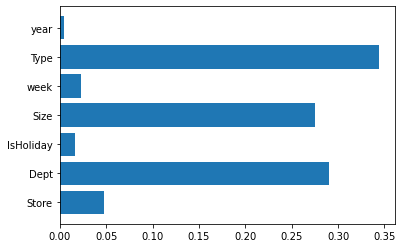

In [316]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(15, 10))
plt.barh(X_train.columns, reg.feature_importances_)
plt.savefig('./tmp.png', dpi=100)

In [ ]:
plt.figure(figsize=(1000, 1000))
plot_tree(reg, num_trees=10, rankdir='LR')
plt.savefig('./tmp.png', dpi=1000)

# Test set - submission to kaggle

In [318]:
df_train_all = df.copy()

df_train_all = df_train_all[ df_train_all['Weekly_Sales'].apply(lambda x: x >= 0) ]

min_sales = df_train_all['Weekly_Sales'].min()
min_sales

0.0

In [329]:
df_test = pd.read_csv('./csv/test.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])


df_test = pd.merge(df_test, df_feat, on=['Store', 'Date', 'IsHoliday'], how = 'left')
df_test = pd.merge(df_test, df_store, on=['Store'], how = 'left' )

fill_na_cols = [ 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5' ]

for c in fill_na_cols:
    df_test[c] = df_test[c].fillna(0)

df_test['MarkDown'] = df_test[fill_na_cols].sum(axis=1)
# df['MarkDown'] = df['MarkDown3'].copy()
# df_test = df_test.drop(columns = fill_na_cols)

df_test['year'] = df_test['Date'].dt.year
df_test['week'] = df_test['Date'].dt.week
df_test['month'] = df_test['Date'].dt.month

label=LabelEncoder()

cols = ['Type', 'IsHoliday']

for c in cols:
    df_test[c] = label.fit_transform(df_test[c])
    df_test[c] = df_test[c].astype('category')
    
df_test = df_test[ ['Date', 'Store','Dept','IsHoliday','Size','week','Type','year'] ]

/tmp/ipykernel_247/2479318142.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_test['week'] = df_test['Date'].dt.week


In [320]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       115064 non-null  datetime64[ns]
 1   Store      115064 non-null  int64         
 2   Dept       115064 non-null  int64         
 3   IsHoliday  115064 non-null  category      
 4   Size       115064 non-null  int64         
 5   week       115064 non-null  int64         
 6   Type       115064 non-null  category      
 7   year       115064 non-null  int64         
 8   Date       115064 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](2), int64(5)
memory usage: 7.2 MB


In [321]:
X = df_train_all.drop(columns = ['Weekly_Sales', 'Date'])
Y = df_train_all['Weekly_Sales']


reg = xgb.XGBRegressor(tree_method = 'gpu_hist', objective='reg:squarederror', max_depth=14, n_estimators= 300, learning_rate=0.1, subsample = 1,
                      enable_categorical=True)

reg.fit(X_train, Y_train )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=14, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [322]:
pred = pd.Series( reg.predict(X) ).apply(lambda x: 0 if x < 0 else x )

print( r2_score( pred,Y.reset_index(drop=True) ) )
print( np.mean( np.absolute( np.array( Y.tolist() ) - pred ) ) )
print( WMAE(pred, Y.reset_index(drop=True), 
     X['IsHoliday'].reset_index(drop=True)) )

0.9964813657090866
601.6668941405362
598.9489204996019


In [323]:
df_test

,Date,Store,Dept,IsHoliday,Size,week,Type,year,Date
0,2012-11-02,1,1,0,151315,44,0,2012,2012-11-02
1,2012-11-09,1,1,0,151315,45,0,2012,2012-11-09
2,2012-11-16,1,1,0,151315,46,0,2012,2012-11-16
3,2012-11-23,1,1,1,151315,47,0,2012,2012-11-23
4,2012-11-30,1,1,0,151315,48,0,2012,2012-11-30
...,...,...,...,...,...,...,...,...,...
115059,2013-06-28,45,98,0,118221,26,1,2013,2013-06-28
115060,2013-07-05,45,98,0,118221,27,1,2013,2013-07-05
115061,2013-07-12,45,98,0,118221,28,1,2013,2013-07-12
115062,2013-07-19,45,98,0,118221,29,1,2013,2013-07-19


In [330]:
X_test = df_test.drop(columns = ['Date'])

pred = pd.Series( reg.predict(X_test) ).apply(lambda x: 0 if x < 0 else x )

In [331]:
df_test['Weekly_Sales'] = pred
def concat(x):
    return str( f"{x['Store']}_{x['Dept']}_{str(x['Date']).split(' ')[0]}" )
df_test['Id'] = df_test.apply(lambda x: concat(x), axis=1)

In [332]:
submission = df_test[['Id', 'Weekly_Sales']]
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            115064 non-null  object 
 1   Weekly_Sales  115064 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.6+ MB


In [333]:
submission.to_csv('submission.csv', index=False)

In [334]:
submission

,Id,Weekly_Sales
0,1_1_2012-11-02,30847.707031
1,1_1_2012-11-09,18672.978516
2,1_1_2012-11-16,19117.847656
3,1_1_2012-11-23,20100.515625
4,1_1_2012-11-30,24027.285156
...,...,...
115059,45_98_2013-06-28,303.351135
115060,45_98_2013-07-05,793.873047
115061,45_98_2013-07-12,623.585022
115062,45_98_2013-07-19,654.877136


In [55]:
submission

,Id,Weekly_Sales
0,1_1_2012-11-02,32641.882812
1,1_1_2012-11-09,19325.677734
2,1_1_2012-11-16,19590.519531
3,1_1_2012-11-23,20670.052734
4,1_1_2012-11-30,21435.574219
...,...,...
115059,45_98_2013-06-28,641.200500
115060,45_98_2013-07-05,750.375916
115061,45_98_2013-07-12,695.191528
115062,45_98_2013-07-19,674.528870


In [335]:
102/688

0.14825581395348839